In [153]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Variables
raw_data_root = './data'
max_features_to_explore = 40
random_seed = 77

In [3]:
raw_data = pd.read_csv('data/pizza_v1.csv')
raw_data

,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,A,"Rp235,000",22.0,chicken,double_signature,jumbo,yes,yes
1,A,"Rp198,000",20.0,papperoni,double_signature,jumbo,yes,yes
2,A,"Rp120,000",16.0,mushrooms,double_signature,reguler,yes,yes
3,A,"Rp155,000",14.0,smoked beef,double_signature,reguler,yes,no
4,A,"Rp248,000",18.0,mozzarella,double_signature,jumbo,yes,no
...,...,...,...,...,...,...,...,...
124,E,"Rp39,000",8.5,tuna,spicy tuna,small,yes,yes
125,E,"Rp72,000",12.0,tuna,spicy tuna,medium,yes,yes
126,E,"Rp99,000",14.0,tuna,spicy tuna,large,yes,yes
127,E,"Rp44,000",8.5,meat,BBQ_meat_fiesta,small,yes,no


In [32]:

categorical_features = ['company', 'topping', 'variant', 'size', 'extra_sauce', 'extra_cheese']
enc = OneHotEncoder(drop='first')
X_data = pd.DataFrame(
    enc.fit_transform( raw_data[categorical_features] ).toarray(),
    columns = enc.get_feature_names_out()
)
numerical_features = ['diameter']
X_data[numerical_features] = raw_data[numerical_features]


In [33]:
X_data.columns

Index(['company_B', 'company_C', 'company_D', 'company_E',
       'topping_black papper', 'topping_chicken', 'topping_meat',
       'topping_mozzarella', 'topping_mushrooms', 'topping_onion',
       'topping_papperoni', 'topping_sausage', 'topping_smoked beef',
       'topping_tuna', 'topping_vegetables', 'variant_BBQ_sausage',
       'variant_american_classic', 'variant_american_favorite',
       'variant_classic', 'variant_crunchy', 'variant_double_decker',
       'variant_double_mix', 'variant_double_signature',
       'variant_extravaganza', 'variant_gournet_greek',
       'variant_italian_veggie', 'variant_meat_eater', 'variant_meat_lovers',
       'variant_neptune_tuna', 'variant_new_york', 'variant_spicy tuna',
       'variant_spicy_tuna', 'variant_super_supreme', 'variant_thai_veggie',
       'size_jumbo', 'size_large', 'size_medium', 'size_reguler', 'size_small',
       'extra_sauce_yes', 'extra_cheese_yes', 'diameter'],
      dtype='object')

In [115]:
price_usd  = raw_data['price_rupiah'].apply(lambda x :
    round( int( x[2:].replace(',', '')) / 14078.56, 2)
)
y_data = np.vectorize( lambda x : 1 if (x>10) else 0 
    )(price_usd.to_numpy())
# y_data = price_usd


In [116]:
X_train, X_test, y_train, y_test = train_test_split( 
    X_data, y_data,
     
    random_state=random_seed)

## Classification

In [117]:


model = DecisionTreeClassifier(
    random_state = random_seed
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [129]:


ensemble = BaggingClassifier(
    base_estimator=model,
    n_estimators = 50,
    random_state = random_seed,
    oob_score=True,
)

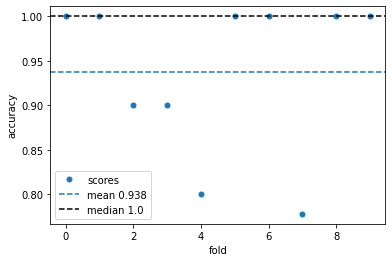

In [130]:
scores = cross_val_score(
    estimator = ensemble,
    X = X_train,
    y = y_train,
    cv = 10,
    scoring = 'accuracy'
)


plt.xlabel('fold')
plt.ylabel('accuracy')
plt.plot(scores, '.', label='scores', ms=10)
mean = np.mean(scores)
plt.axhline( label=f'mean {mean:.3}', y=mean, linestyle='--')
median = np.median(scores)
plt.axhline( label=f'median {median:.3}', y=median, linestyle='--', color = 'black')
plt.legend()

In [139]:
test_acc = accuracy_score(y_test, y_pred)

print(test_acc)

1.0


In [59]:
y_test

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Regression

In [141]:
y_data = price_usd
X_train, X_test, y_train, y_test = train_test_split( 
    X_data, y_data,
    random_state=random_seed)

In [144]:
model = RandomForestRegressor(
    n_estimators = 25,
    random_state = random_seed
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [156]:
model = GradientBoostingRegressor(
    n_estimators = 25,
    subsample=0.9,
    random_state = random_seed
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [146]:
mean_squared_error(y_test,y_pred) ** 0.5

0.654873948546473

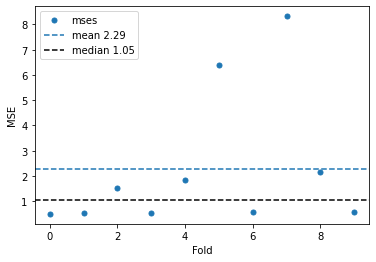

In [157]:
mses = - cross_val_score(
    estimator = model,
    X = X_train,
    y = y_train,
    cv = 10,
    scoring = 'neg_mean_squared_error'
)


plt.xlabel('Fold')
plt.ylabel('MSE')
plt.plot(mses, '.', label='mses', ms=10)
mean = np.mean(mses)
plt.axhline( label=f'mean {mean:.3}', y=mean, linestyle='--')
median = np.median(mses)
plt.axhline( label=f'median {median:.3}', y=median, linestyle='--', color = 'black')
plt.legend()


<AxesSubplot:>

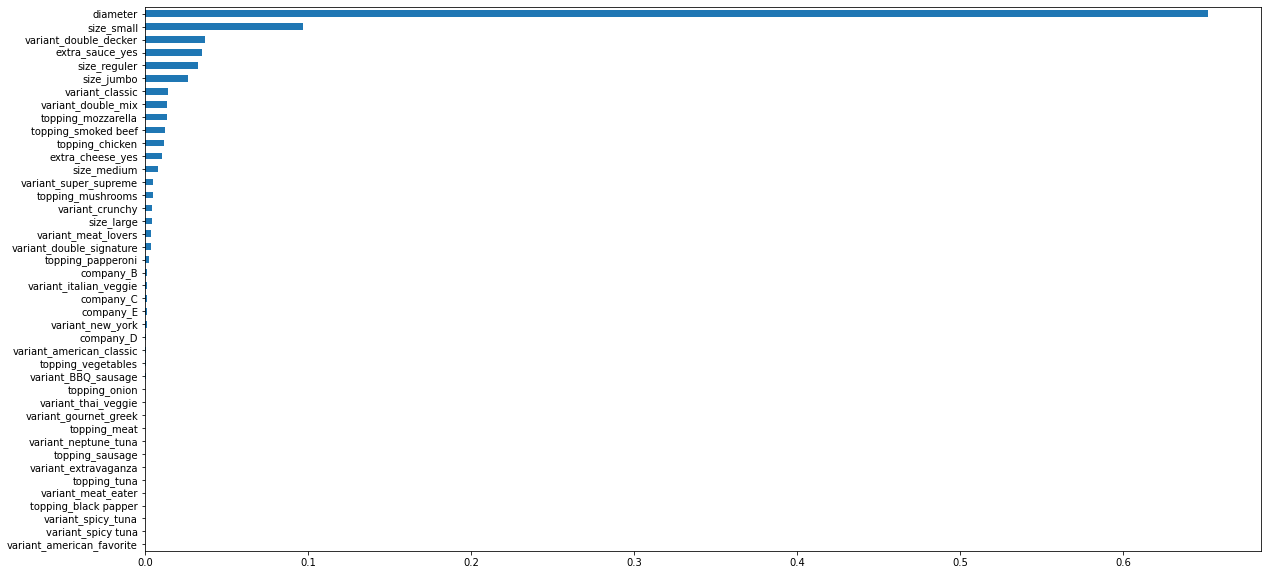

In [151]:
importances = pd.Series(
    data = model.feature_importances_, 
    index = X_train.columns, 
)
fig, ax = plt.subplots(figsize=(20,10))
importances.sort_values().plot(
    kind='barh',
    ax=ax,
)